# Question c (Part 2 PCA Reduction): Can we predict the maximum strength of a storm?
For this question, we decided to only use starting and current known conditions to predict the maximum strength of a storm. Indeed, we are interested in predicting the maximum strenght of an storm at the beginning or in the midst of an storm, not at the end when we have all the fact. Therefore variables that can be determined only after the end of the storm such as Duration, EndLat, MinWind, MaxPressure will be excluded.

We will use only the following variables
- TimeSinceStart
- Lon
- Lat
- Wind
- Pressure 
- Season
- Storm Type
- MaxStrength (Target variable)
- StartLat
- StartLon
- StartWind
- StartPressure
- StartStormType

reframing the question, can we predict the maximum strength of a storm given the starting and current conditions?

# 5) Techniques used to answer the question.

For Question c, the task is  to build a classifier to predict the maximum strenght of a storm. We considered multiples classification estimators suitable with the size and shape of our dataset. Hence, we considered the five following estimators: Logistic Regression, Naive Bayes, K-nearest Neighbors, Decision Tree, and Random Forest classifiers.


For each of our models, we apply the following pipeline: spliting dataset into trainning and test sets, scaling if neccessary, hyperparameters tuning, model fit, cross validation and test.

Additionally, we use f1_macro as a performance metric to evaluate our model because of the class imbalance in the target variable and the fact that we care about both precison and recall, false positive and false negative globally, and all classes equally. This makes accuracy a misleading performance metric.

For this second part, we did dimensionality reduction through PCA to reduce the number of features in our models.

# 6) Analysis

In [1]:
import numpy as np
import pandas as pd
import seaborn as sb
import matplotlib.pyplot as plt
import sklearn

from pandas import Series, DataFrame
from pylab import rcParams
from sklearn import preprocessing
from sklearn.model_selection import train_test_split

In [2]:
%matplotlib inline
rcParams['figure.figsize'] = 30, 8
rcParams["axes.labelsize"] = 20
sb.set_style('whitegrid')
sb.set(font_scale = 1.5)

# Dataset and Preprocessing

In [3]:
df_start=pd.read_csv('StormDatasetFinal.csv')
df_initial=df_start[['TimeSinceStart','Lat', 'Lon', 'Wind', 'Pressure', 'Season', 'StormType', 'MaxStrength', 'StartLat', 'StartLon',
              'StartWind', 'StartPressure', 'StartStormType']]
df_initial.head()

TimeSinceStart    Lat     Lon  Wind  Pressure  Season     StormType  \
0               0  15.90 -82.000    29      1007  Summer  Tropical Low   
1           10800  15.95 -82.040    29      1006  Summer  Tropical Low   
2           21600  16.00 -82.100    29      1006  Summer  Tropical Low   
3           32400  16.05 -82.193    29      1006  Summer  Tropical Low   
4           43200  16.10 -82.300    29      1006  Summer  Tropical Low   

  MaxStrength  StartLat  StartLon  StartWind  StartPressure StartStormType  
0   Hurricane      15.9     -82.0         29           1007   Tropical Low  
1   Hurricane      15.9     -82.0         29           1007   Tropical Low  
2   Hurricane      15.9     -82.0         29           1007   Tropical Low  
3   Hurricane      15.9     -82.0         29           1007   Tropical Low  
4   Hurricane      15.9     -82.0         29           1007   Tropical Low

In [4]:
df= df_initial.copy()
#dopping Null-values rows (23)
df = df.dropna()  

In [5]:
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()
df_encoded = df.copy()
#encoding season
df_encoded['Season'] = label_encoder.fit_transform(df_encoded['Season'])

# Dataset Splitting

In [6]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(df_encoded.drop('MaxStrength', axis=1),
                                                   df_encoded['MaxStrength'], test_size=0.20,
                                                   random_state=312, stratify= df_encoded['MaxStrength'])

In [7]:
print(X_train.shape)
print(y_train.shape)

(8340, 12)
(8340,)


### Encoding categorical variables/ storm columns using semi-ordinal label encoding
We encoded StormType, MaxStrength, and StartStormType using label encoding

In [8]:
dic_to_replace = {'Tropical Disturbance': 1, 'Tropical Low': 2, 'Tropical Wave': 3, 'Subtropical Depression': 4, 
                  'Tropical Depression': 5, 'Post-Tropical Cyclone': 6, 'Extratropical': 7, 'Subtropical Storm': 8,
                  'Tropical Storm': 9, 'Hurricane': 10, 'Category 1 Hurricane': 11, 'Category 2 Hurricane': 12, 
                  'Category 3 Major Hurricane': 13, 'Category 4 Major Hurricane': 14, 'Category 5 Major Hurricane': 15}

X_train=X_train.replace(dic_to_replace)
X_test=X_test.replace(dic_to_replace)

# Scaling

In [9]:
from sklearn.preprocessing import StandardScaler

sc = StandardScaler()
norm_X_train = sc.fit_transform(X_train)
norm_X_test = sc.transform(X_test)

# Dimentionality Reduction: PCA

In [10]:
from sklearn.decomposition import PCA
pca = PCA()

### Finding the number of components
We want to find the minimum number of components such that we will be able to retain 90% of the variance in the dataset

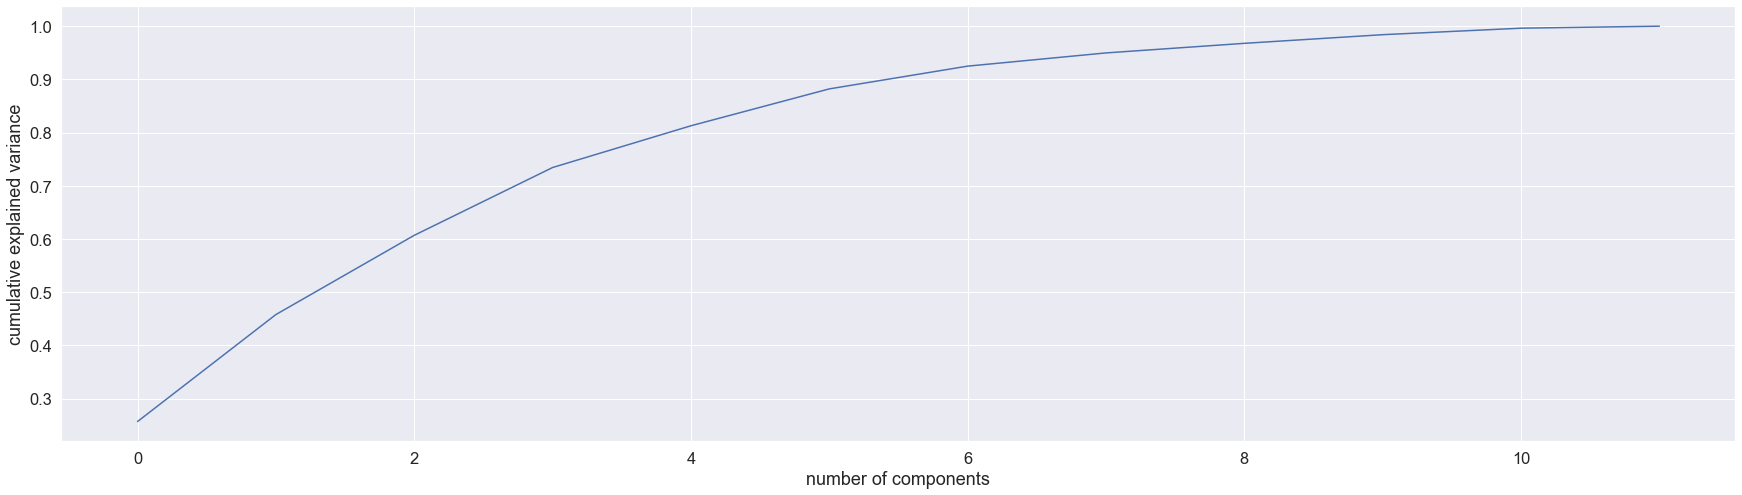

In [11]:
pca = PCA().fit(norm_X_train)
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance');

The first five componnents explains about 90% of the variance in the training set. Hence we, set n_components= 5

In [12]:
pca = PCA(n_components=5)
norm_X_train = pca.fit_transform(norm_X_train)
norm_X_test = pca.transform(norm_X_test)

In [13]:
# number of components
n_pcs= pca.components_.shape[0]

# get the index of the most important feature on EACH component
# LIST COMPREHENSION HERE
most_important = [np.abs(pca.components_[i]).argmax() for i in range(n_pcs)]

initial_feature_names = X_train.columns
# get the names
most_important_names = [initial_feature_names[most_important[i]] for i in range(n_pcs)]

# LIST COMPREHENSION HERE AGAIN
dic = {'PC{}'.format(i): most_important_names[i] for i in range(n_pcs)}

# build the dataframe
df = pd.DataFrame(dic.items())
df

0          1
0  PC0       Wind
1  PC1  StartWind
2  PC2        Lat
3  PC3        Lon
4  PC4     Season

In [14]:
# Dump components relations with features:
pd.DataFrame(pca.components_,columns=X_train.columns, )

TimeSinceStart       Lat       Lon      Wind  Pressure    Season  \
0        0.293947  0.088652  0.115649  0.511040 -0.506388 -0.197765   
1       -0.115362  0.221829 -0.195490  0.014143 -0.059324  0.093945   
2        0.284015  0.507513 -0.217530  0.103625 -0.160071  0.205397   
3        0.302854  0.430353  0.606851 -0.238528  0.166178 -0.150826   
4        0.367910  0.129730 -0.293983 -0.165821  0.032833 -0.653434   

   StormType  StartLat  StartLon  StartWind  StartPressure  StartStormType  
0   0.468327 -0.147772  0.235360   0.072699      -0.119490        0.139770  
1   0.042848  0.371581 -0.377808   0.529859      -0.301416        0.482154  
2   0.064001  0.364415 -0.283330  -0.279221       0.418099       -0.256819  
3  -0.205025  0.215839  0.329929   0.119605       0.044135        0.183903  
4  -0.193471 -0.137029 -0.261824  -0.140347      -0.382737       -0.122029

# Logistic regression
Although scaling is not required for logistic regression, we will use the scaled dataset to speed up convergence.

In [15]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV

from sklearn import metrics
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score, recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import plot_confusion_matrix

### Hyperparameters Tuning
For this logistic regression model, we want to determine the best set of solver and multi_class to use. We are using a balanced class_weight because the target variable is highly imbalnced.

In [16]:
parameters = {'solver':('newton-cg', 'saga' , 'sag', 'lbfgs'), 'multi_class':('multinomial', 'ovr')}

In [17]:
LogReg=LogisticRegression(class_weight='balanced', max_iter=5000)

In [18]:
from sklearn.model_selection import StratifiedKFold
cv_method = StratifiedKFold(n_splits=10, shuffle=True, random_state=123)   #for stratified folds

In [19]:
import warnings
warnings.filterwarnings("ignore")
gs = GridSearchCV(LogReg, parameters, scoring='f1_macro', cv=cv_method, refit=True)
gs.fit(norm_X_train, y_train);

In [20]:
print('The best model is:', gs.best_estimator_)
print('which yielded a mean macro f1_score of', gs.best_score_)

The best model is: LogisticRegression(class_weight='balanced', max_iter=5000, multi_class='ovr',
                   solver='newton-cg')
which yielded a mean macro f1_score of 0.4411578658847555


### Model

In [21]:
RegModel=gs.best_estimator_

The best Logistic regression estimator has the solver and class_class parameters set at newton-cg and one versus rest (ovr).

In [22]:
y_train_pred = RegModel.predict(norm_X_train)

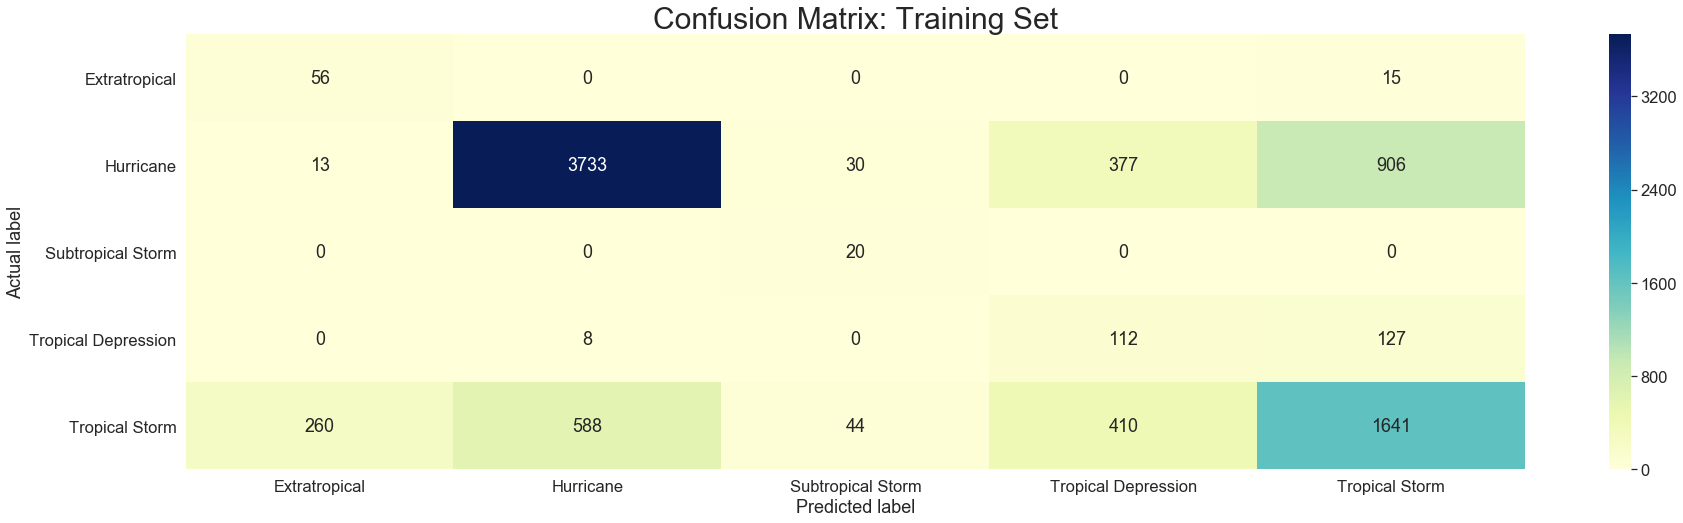

In [23]:
cf_train_matrix = confusion_matrix(y_train, y_train_pred)
class_names=('Extratropical', 'Hurricane', 'Subtropical Storm', 'Tropical Depression', 'Tropical Storm') # name  of classes
# create heatmap
chart=sb.heatmap(pd.DataFrame(cf_train_matrix), annot=True, cmap="YlGnBu",fmt='g')
chart.set_title('Confusion Matrix: Training Set', size=30)
chart.set_ylabel('Actual label')
chart.set_xlabel('Predicted label')
class_names=['Extratropical', 'Hurricane', 'Subtropical Storm', 'Tropical Depression', 'Tropical Storm']
chart.set_xticklabels(class_names, rotation=0)
chart.set_yticklabels(class_names, rotation=0);

#### Classification Report: Training Set

In [24]:
print(classification_report(y_train, y_train_pred))

                     precision    recall  f1-score   support

      Extratropical       0.17      0.79      0.28        71
          Hurricane       0.86      0.74      0.80      5059
  Subtropical Storm       0.21      1.00      0.35        20
Tropical Depression       0.12      0.45      0.20       247
     Tropical Storm       0.61      0.56      0.58      2943

           accuracy                           0.67      8340
          macro avg       0.40      0.71      0.44      8340
       weighted avg       0.74      0.67      0.70      8340



In [25]:
print('The macro f1_score for the training set is', f1_score(y_train, y_train_pred, average='macro'))

The macro f1_score for the training set is 0.4408703413199054


### K-fold cross-validation

In [26]:
y_val_pred = cross_val_predict(RegModel, norm_X_train, y_train, cv = cv_method)

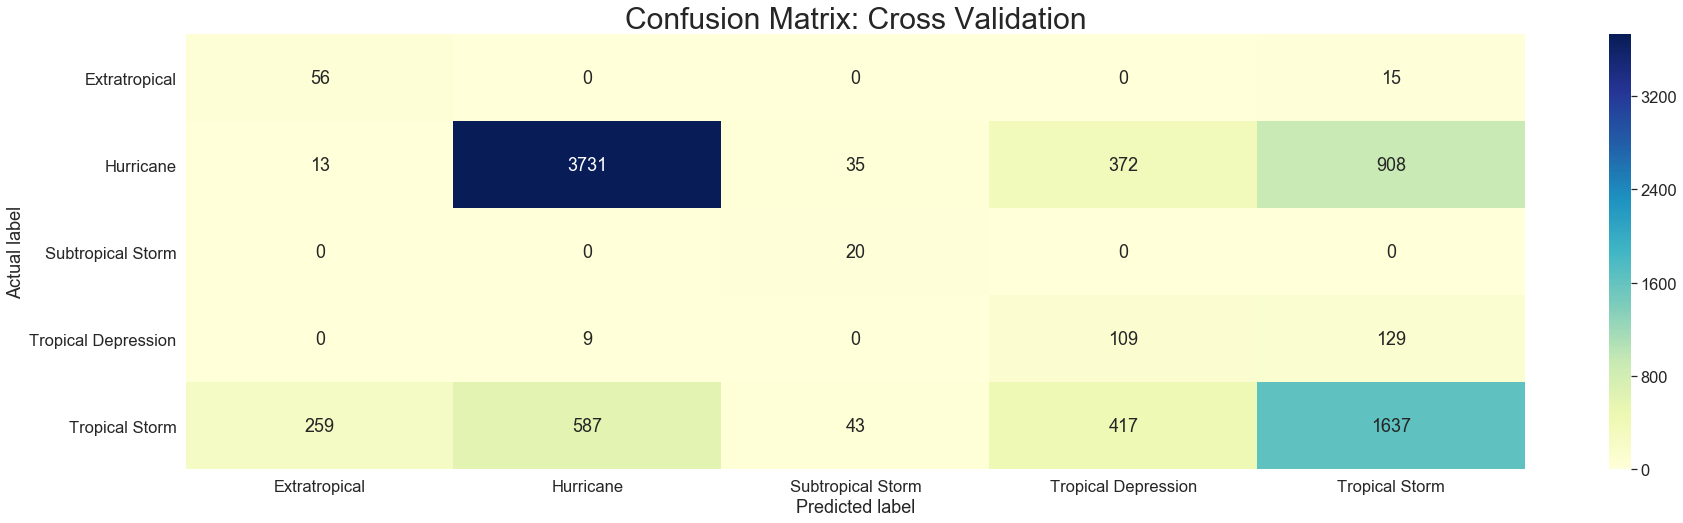

In [27]:
cf_val_matrix = confusion_matrix(y_train, y_val_pred)
chart=sb.heatmap(pd.DataFrame(cf_val_matrix), annot=True, cmap="YlGnBu",fmt='g')
chart.set_title('Confusion Matrix: Cross Validation', size=30)
chart.set_ylabel('Actual label')
chart.set_xlabel('Predicted label')
class_names=['Extratropical', 'Hurricane', 'Subtropical Storm', 'Tropical Depression', 'Tropical Storm']
chart.set_xticklabels(class_names, rotation=0)
chart.set_yticklabels(class_names, rotation=0);

#### Classification Report: Cross Validation

In [28]:
print(classification_report(y_train, y_val_pred))

                     precision    recall  f1-score   support

      Extratropical       0.17      0.79      0.28        71
          Hurricane       0.86      0.74      0.80      5059
  Subtropical Storm       0.20      1.00      0.34        20
Tropical Depression       0.12      0.44      0.19       247
     Tropical Storm       0.61      0.56      0.58      2943

           accuracy                           0.67      8340
          macro avg       0.39      0.70      0.44      8340
       weighted avg       0.74      0.67      0.70      8340



In [29]:
print('The macro f1_score for cross validation is', f1_score(y_train, y_val_pred, average='macro'))

The macro f1_score for cross validation is 0.4372825382953289


### Deploying and evaluating the model on the test set

#### Classification Report: Cross Validation

In [30]:
y_pred = RegModel.predict(norm_X_test)

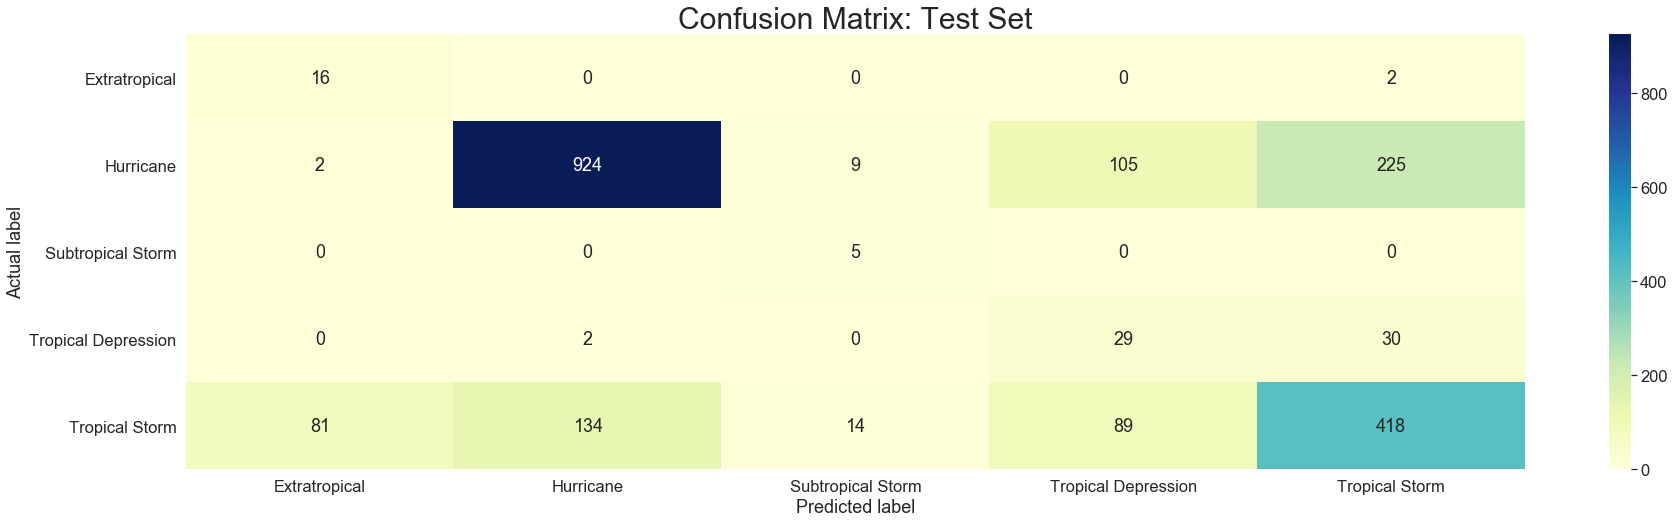

In [31]:
cf_test_matrix = confusion_matrix(y_test, y_pred)
chart=sb.heatmap(pd.DataFrame(cf_test_matrix), annot=True, cmap="YlGnBu",fmt='g')
chart.set_title('Confusion Matrix: Test Set', size=30)
chart.set_ylabel('Actual label')
chart.set_xlabel('Predicted label')
class_names=['Extratropical', 'Hurricane', 'Subtropical Storm', 'Tropical Depression', 'Tropical Storm']
chart.set_xticklabels(class_names, rotation=0)
chart.set_yticklabels(class_names, rotation=0);

#### Classification Report: Test Set

In [32]:
print(classification_report(y_test, y_pred))

                     precision    recall  f1-score   support

      Extratropical       0.16      0.89      0.27        18
          Hurricane       0.87      0.73      0.79      1265
  Subtropical Storm       0.18      1.00      0.30         5
Tropical Depression       0.13      0.48      0.20        61
     Tropical Storm       0.62      0.57      0.59       736

           accuracy                           0.67      2085
          macro avg       0.39      0.73      0.43      2085
       weighted avg       0.75      0.67      0.70      2085



In [33]:
print('The macro f1_score for the test set is', f1_score(y_test, y_pred, average='macro'))

The macro f1_score for the test set is 0.433617247154658


## Applying Synthetic Minority Oversampling Technique (SMOTE)

In [34]:
from imblearn.over_sampling import SMOTE
sm = SMOTE(random_state = 2)
X_train_res, y_train_res = sm.fit_sample(norm_X_train, y_train.ravel())
print(X_train_res.shape)
print(y_train_res.shape)

(25295, 5)
(25295,)


In [35]:
import warnings
warnings.filterwarnings("ignore")
gs_res = GridSearchCV(LogReg, parameters, scoring='f1_macro', cv=10, refit=True)
gs_res.fit(X_train_res, y_train_res)
print('The best model is:', gs_res.best_estimator_)
print('which yielded a mean macro f1_score of', gs_res.best_score_)

The best model is: LogisticRegression(class_weight='balanced', max_iter=5000,
                   multi_class='multinomial', solver='newton-cg')
which yielded a mean macro f1_score of 0.7921781877388321


### Training

In [36]:
RegModelRes=gs_res.best_estimator_

In [37]:
y_train_pred = RegModelRes.predict(X_train_res)

#### Classification Report: Training Set

In [38]:
print(classification_report(y_train_res, y_train_pred))

                     precision    recall  f1-score   support

      Extratropical       0.89      1.00      0.94      5059
          Hurricane       0.78      0.73      0.75      5059
  Subtropical Storm       0.98      1.00      0.99      5059
Tropical Depression       0.73      0.82      0.77      5059
     Tropical Storm       0.57      0.45      0.51      5059

           accuracy                           0.80     25295
          macro avg       0.79      0.80      0.79     25295
       weighted avg       0.79      0.80      0.79     25295



In [39]:
print('The macro f1_score for the training set is', f1_score(y_train_res, y_train_pred, average='macro'))

The macro f1_score for the training set is 0.7932061155226282


### K-fold Cross Validation

In [40]:
y_val_pred = cross_val_predict(RegModelRes, norm_X_train, y_train, cv = cv_method)

#### Classification Report: Cross Validation

In [41]:
print(classification_report(y_train, y_val_pred))

                     precision    recall  f1-score   support

      Extratropical       0.16      1.00      0.28        71
          Hurricane       0.86      0.73      0.79      5059
  Subtropical Storm       0.15      1.00      0.27        20
Tropical Depression       0.15      0.80      0.26       247
     Tropical Storm       0.60      0.45      0.51      2943

           accuracy                           0.63      8340
          macro avg       0.39      0.80      0.42      8340
       weighted avg       0.74      0.63      0.67      8340



In [42]:
print('The macro f1_score for cross validation is', f1_score(y_train, y_val_pred, average='macro'))

The macro f1_score for cross validation is 0.4216227152129031


### Deploying and evaluating the model on the test set

In [43]:
y_pred = RegModelRes.predict(norm_X_test)

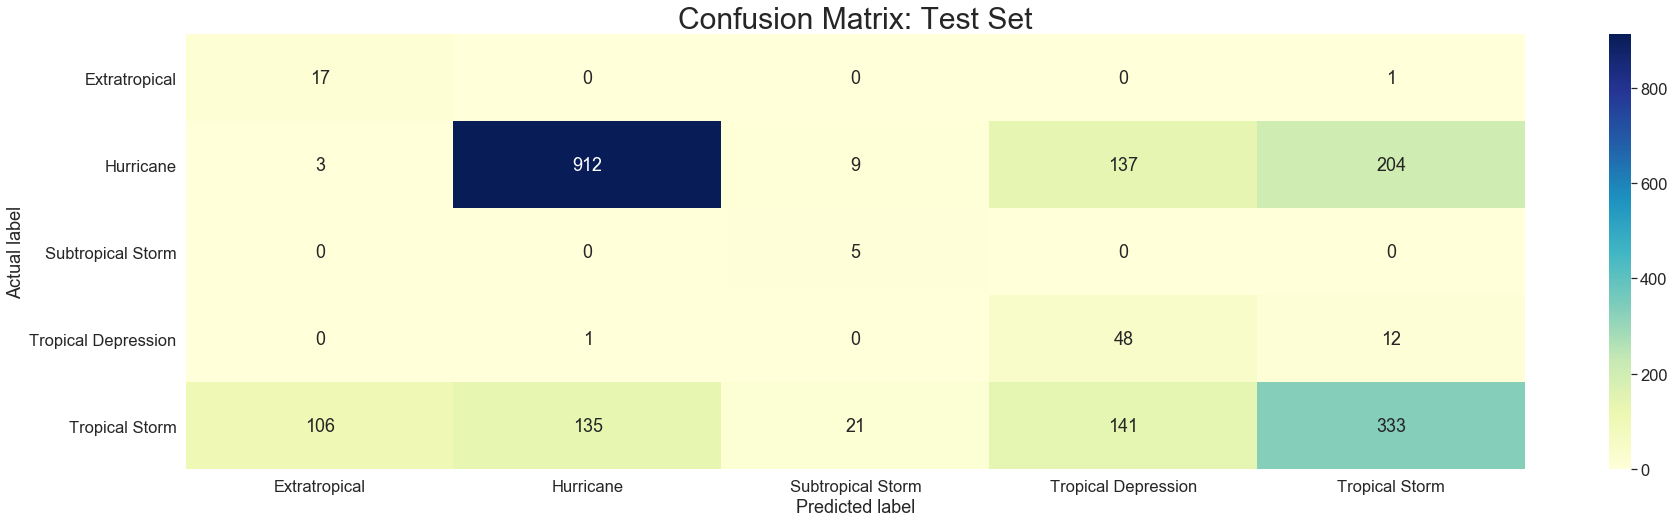

In [44]:
cf_test_matrix = confusion_matrix(y_test, y_pred)
chart=sb.heatmap(pd.DataFrame(cf_test_matrix), annot=True, cmap="YlGnBu", fmt='g')
chart.set_title('Confusion Matrix: Test Set', size=30)
chart.set_ylabel('Actual label')
chart.set_xlabel('Predicted label')
class_names=['Extratropical', 'Hurricane', 'Subtropical Storm', 'Tropical Depression', 'Tropical Storm']
chart.set_xticklabels(class_names, rotation=0)
chart.set_yticklabels(class_names, rotation=0);

#### Classification Report: Test Set

In [45]:
print(classification_report(y_test, y_pred))

                     precision    recall  f1-score   support

      Extratropical       0.13      0.94      0.24        18
          Hurricane       0.87      0.72      0.79      1265
  Subtropical Storm       0.14      1.00      0.25         5
Tropical Depression       0.15      0.79      0.25        61
     Tropical Storm       0.61      0.45      0.52       736

           accuracy                           0.63      2085
          macro avg       0.38      0.78      0.41      2085
       weighted avg       0.75      0.63      0.67      2085



In [46]:
print('The macro f1_score for the test set is', f1_score(y_test, y_pred, average='macro'))

The macro f1_score for the test set is 0.40812885853994213


Applying SMOTE did not improve the model at all and introduced an overfitting problem. Indeed, the performance metrics are similar to model's before applying SMOTE.

# Naive Bayes Classifier

In [47]:
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score

### Hyperparameters Tuning
For this Naive Bayes model, we want to determine the optimal var_smoothing or portion of the largest variance of all features that is added to variances for calculation stability.

In [48]:
GausNB = GaussianNB()
parameters = {'var_smoothing': np.logspace(0,-9, num=100)}

In [49]:
import warnings
warnings.filterwarnings("ignore")
gnb = GridSearchCV(GausNB, parameters, scoring='f1_macro', cv=cv_method, refit=True)
gnb.fit(norm_X_train, y_train)
print('The best model is:', gnb.best_estimator_)
print('which yielded a mean macro f1_score of', gnb.best_score_)

The best model is: GaussianNB(var_smoothing=0.0023101297000831605)
which yielded a mean macro f1_score of 0.6211094641016363


We ploted the mean cross validation f1_score as a function of var_smoothing to confirm that the best variance smoothing parameter for this model is 0.

In [50]:
results_NB = pd.DataFrame(gnb.cv_results_['params'])
results_NB['test_score'] = gnb.cv_results_['mean_test_score']

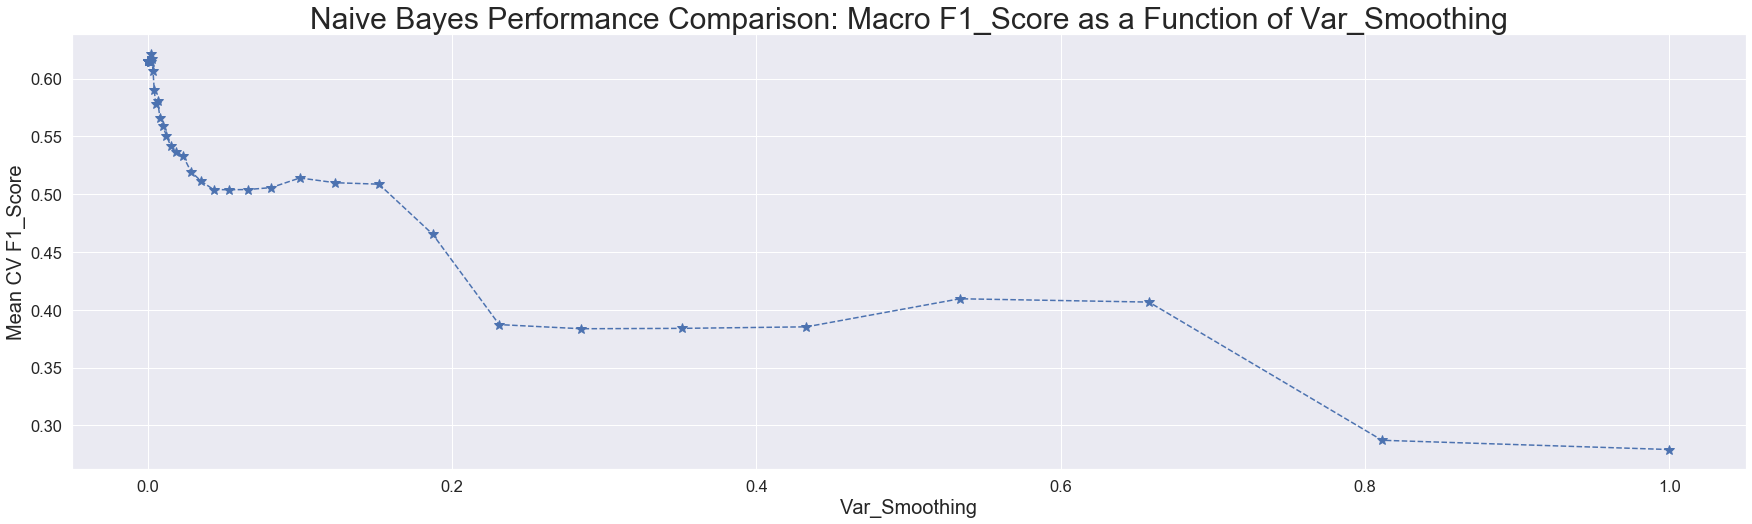

In [51]:
plt.plot(results_NB['var_smoothing'], results_NB['test_score'], marker = '*', linestyle='dashed', markersize=10)    
plt.xlabel('Var_Smoothing', fontsize=20)
plt.ylabel("Mean CV F1_Score", fontsize=20)
plt.title("Naive Bayes Performance Comparison: Macro F1_Score as a Function of Var_Smoothing", fontsize=30)
plt.show()

### Model

In [52]:
NBModel=gnb.best_estimator_
NBModel

GaussianNB(var_smoothing=0.0023101297000831605)

In [53]:
y_train_pred = NBModel.predict(norm_X_train)

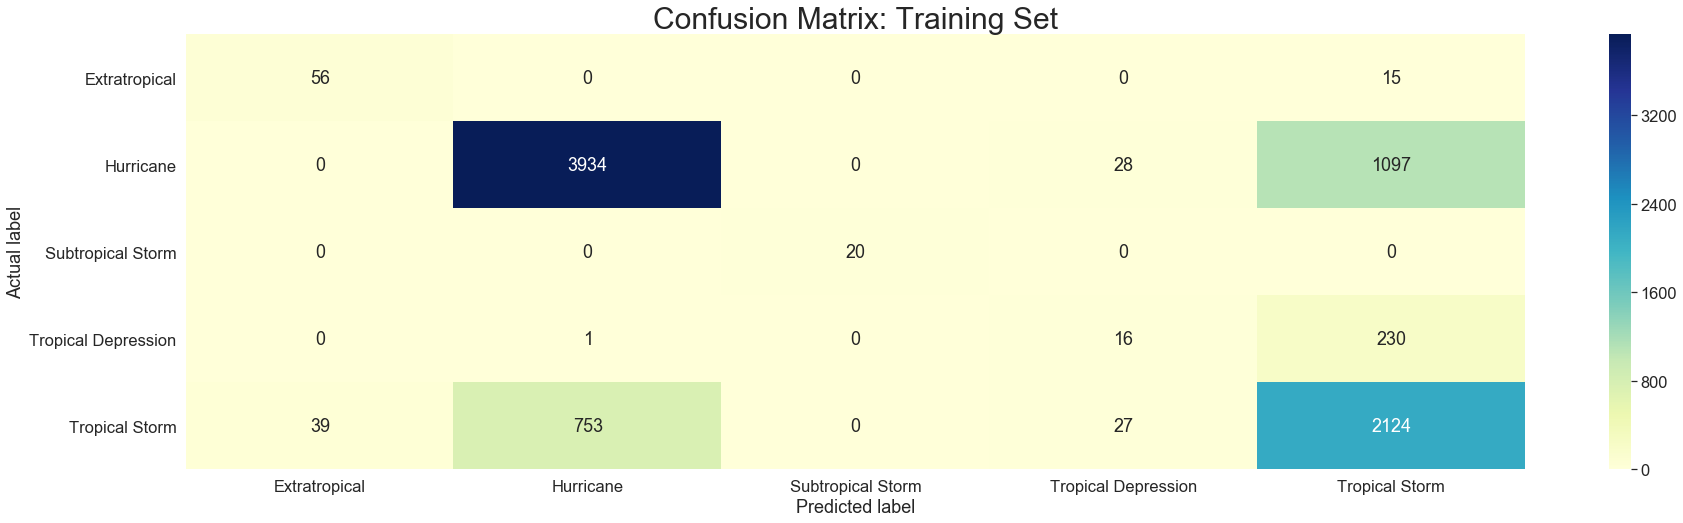

In [54]:
cf_train_matrix = confusion_matrix(y_train, y_train_pred)
class_names=('Extratropical', 'Hurricane', 'Subtropical Storm', 'Tropical Depression', 'Tropical Storm') # name  of classes
# create heatmap
chart=sb.heatmap(pd.DataFrame(cf_train_matrix), annot=True, cmap="YlGnBu",fmt='g')
chart.set_title('Confusion Matrix: Training Set', size=30)
chart.set_ylabel('Actual label')
chart.set_xlabel('Predicted label')
class_names=['Extratropical', 'Hurricane', 'Subtropical Storm', 'Tropical Depression', 'Tropical Storm']
chart.set_xticklabels(class_names, rotation=0)
chart.set_yticklabels(class_names, rotation=0);

#### Classification Report: Training Set

In [55]:
print(classification_report(y_train, y_train_pred))

                     precision    recall  f1-score   support

      Extratropical       0.59      0.79      0.67        71
          Hurricane       0.84      0.78      0.81      5059
  Subtropical Storm       1.00      1.00      1.00        20
Tropical Depression       0.23      0.06      0.10       247
     Tropical Storm       0.61      0.72      0.66      2943

           accuracy                           0.74      8340
          macro avg       0.65      0.67      0.65      8340
       weighted avg       0.74      0.74      0.73      8340



In [56]:
print('The macro f1_score for the training set is', f1_score(y_train, y_train_pred, average='macro'))

The macro f1_score for the training set is 0.649073674701944


### K-fold cross-validation

In [57]:
y_val_pred = cross_val_predict(NBModel, norm_X_train, y_train, cv = cv_method)

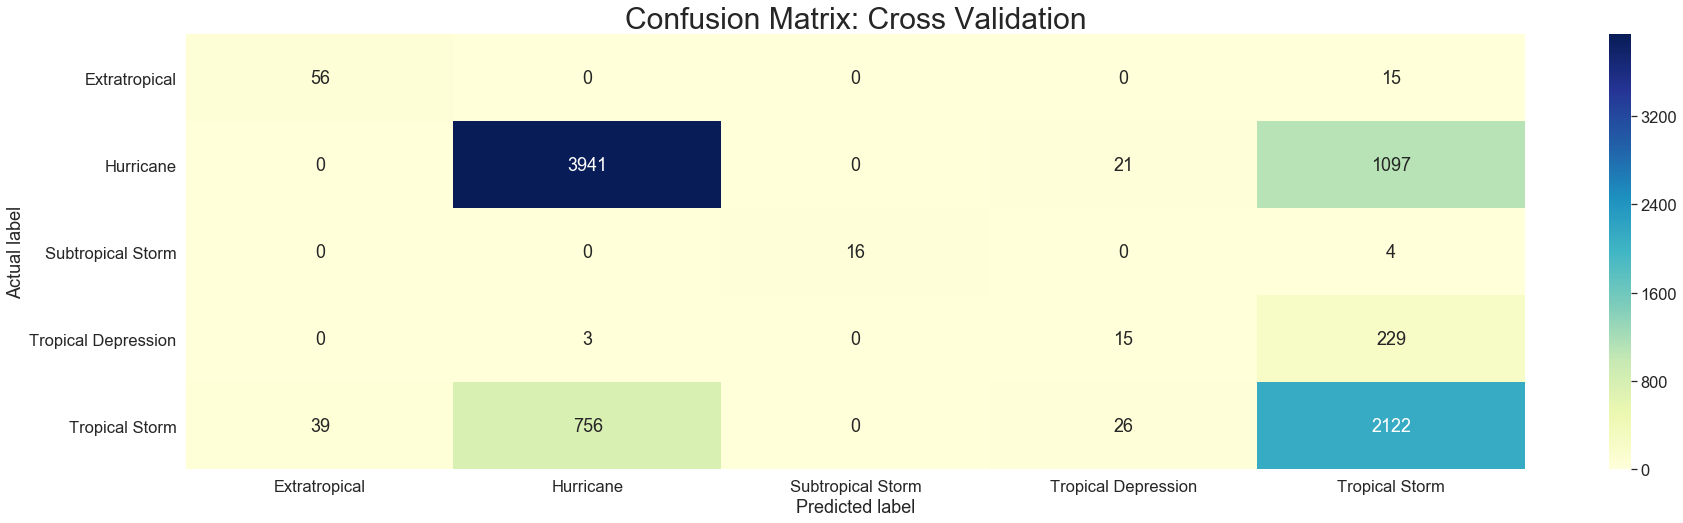

In [58]:
cf_val_matrix = confusion_matrix(y_train, y_val_pred)
chart=sb.heatmap(pd.DataFrame(cf_val_matrix), annot=True, cmap="YlGnBu",fmt='g')
chart.set_title('Confusion Matrix: Cross Validation', size=30)
chart.set_ylabel('Actual label')
chart.set_xlabel('Predicted label')
class_names=['Extratropical', 'Hurricane', 'Subtropical Storm', 'Tropical Depression', 'Tropical Storm']
chart.set_xticklabels(class_names, rotation=0)
chart.set_yticklabels(class_names, rotation=0);

#### Classification Report: Cross Validation

In [59]:
print(classification_report(y_train, y_val_pred))

                     precision    recall  f1-score   support

      Extratropical       0.59      0.79      0.67        71
          Hurricane       0.84      0.78      0.81      5059
  Subtropical Storm       1.00      0.80      0.89        20
Tropical Depression       0.24      0.06      0.10       247
     Tropical Storm       0.61      0.72      0.66      2943

           accuracy                           0.74      8340
          macro avg       0.66      0.63      0.63      8340
       weighted avg       0.74      0.74      0.73      8340



### Deploying and evaluating the model on the test set

In [60]:
y_pred = NBModel.predict(norm_X_test)

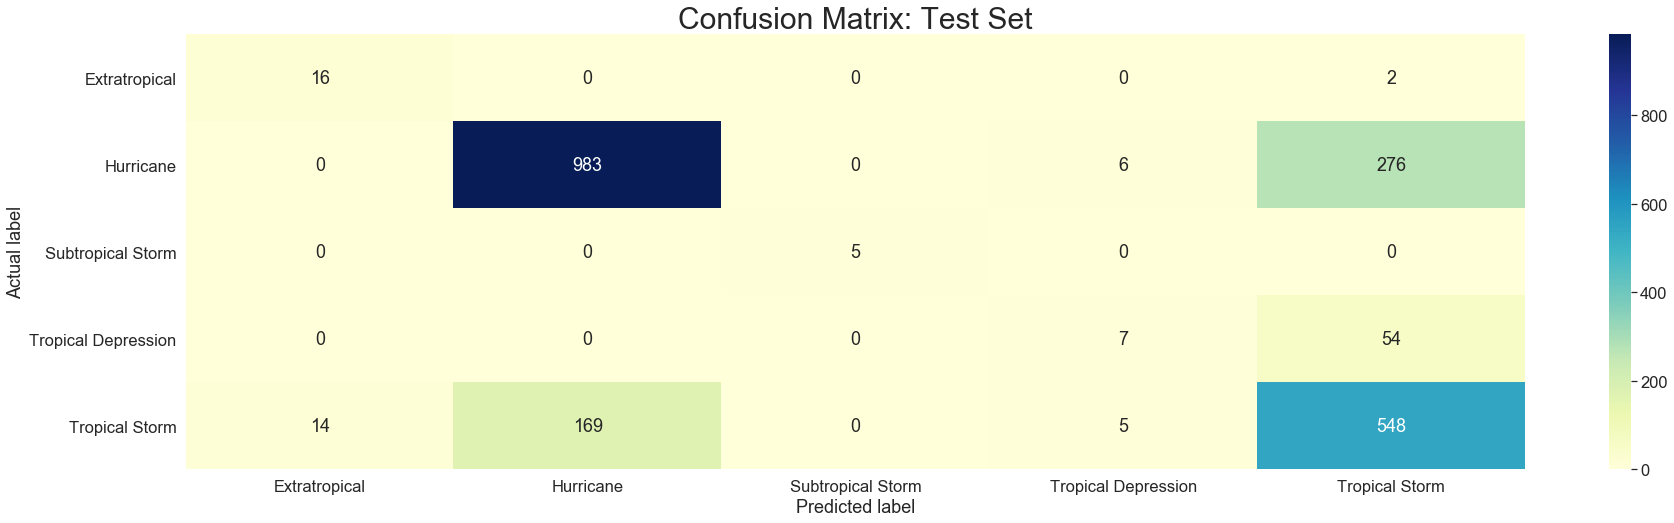

In [61]:
cf_test_matrix = confusion_matrix(y_test, y_pred)
chart=sb.heatmap(pd.DataFrame(cf_test_matrix), annot=True, cmap="YlGnBu", fmt='g')
chart.set_title('Confusion Matrix: Test Set', size=30)
chart.set_ylabel('Actual label')
chart.set_xlabel('Predicted label')
class_names=['Extratropical', 'Hurricane', 'Subtropical Storm', 'Tropical Depression', 'Tropical Storm']
chart.set_xticklabels(class_names, rotation=0)
chart.set_yticklabels(class_names, rotation=0);

#### Classification Report: Test Set

In [62]:
print(classification_report(y_test, y_pred))

                     precision    recall  f1-score   support

      Extratropical       0.53      0.89      0.67        18
          Hurricane       0.85      0.78      0.81      1265
  Subtropical Storm       1.00      1.00      1.00         5
Tropical Depression       0.39      0.11      0.18        61
     Tropical Storm       0.62      0.74      0.68       736

           accuracy                           0.75      2085
          macro avg       0.68      0.71      0.67      2085
       weighted avg       0.76      0.75      0.75      2085



# k-Nearest Neighbor
KNN is a distance based algorithm. Hence, we will use the scaled dataset here.

In [63]:
from sklearn import neighbors
from sklearn.neighbors import KNeighborsClassifier

### Hyperparameter Tuning: Finding the optimal K and distance metric (power parameter for the Minkowski metric)

In [64]:
KNN = KNeighborsClassifier()
parameters= {'n_neighbors': [1, 3, 5, 7, 9], 'p': [1, 2, 5]} #only odd K; p: 1 (Manhattan), 2 (Euclidean), and 5 (Minkowski)

gknn = GridSearchCV(KNN, parameters, cv=cv_method, scoring='f1_macro', refit=True)

In [65]:
gknn.fit(norm_X_train, y_train)
print('The best model is:', gknn.best_estimator_)
print('which yielded a mean macro f1_score of', gknn.best_score_)

The best model is: KNeighborsClassifier(n_neighbors=1, p=1)
which yielded a mean macro f1_score of 0.9978979738621154


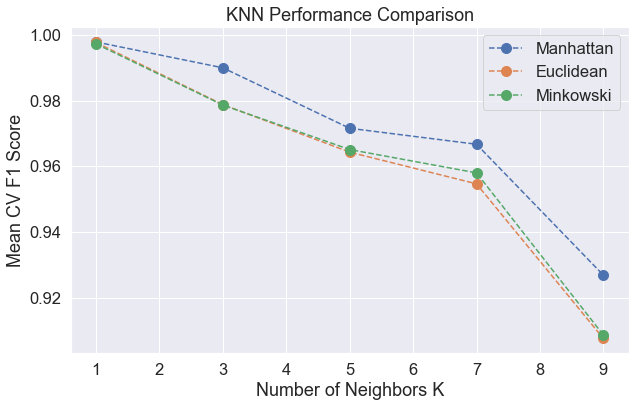

In [66]:
results_KNN = pd.DataFrame(gknn.cv_results_['params'])
results_KNN['test_score'] = gknn.cv_results_['mean_test_score']
results_KNN['metric'] = results_KNN['p'].replace([1,2,5], ["Manhattan", "Euclidean", "Minkowski"])

plt.figure(figsize=(10,6))
for i in ["Manhattan", "Euclidean", "Minkowski"]:
    temp = results_KNN[results_KNN['metric'] == i]
    plt.plot(temp['n_neighbors'], temp['test_score'], linestyle='dashed', marker='o', markersize=10, label = i)
    
plt.legend()
plt.xlabel('Number of Neighbors K')
plt.ylabel("Mean CV F1 Score")
plt.title("KNN Performance Comparison")
plt.show()

### Model

In [67]:
KNNModel=gknn.best_estimator_

### K-fold cross-validation

In [68]:
y_val_pred = cross_val_predict(KNNModel, norm_X_train, y_train, cv = cv_method)

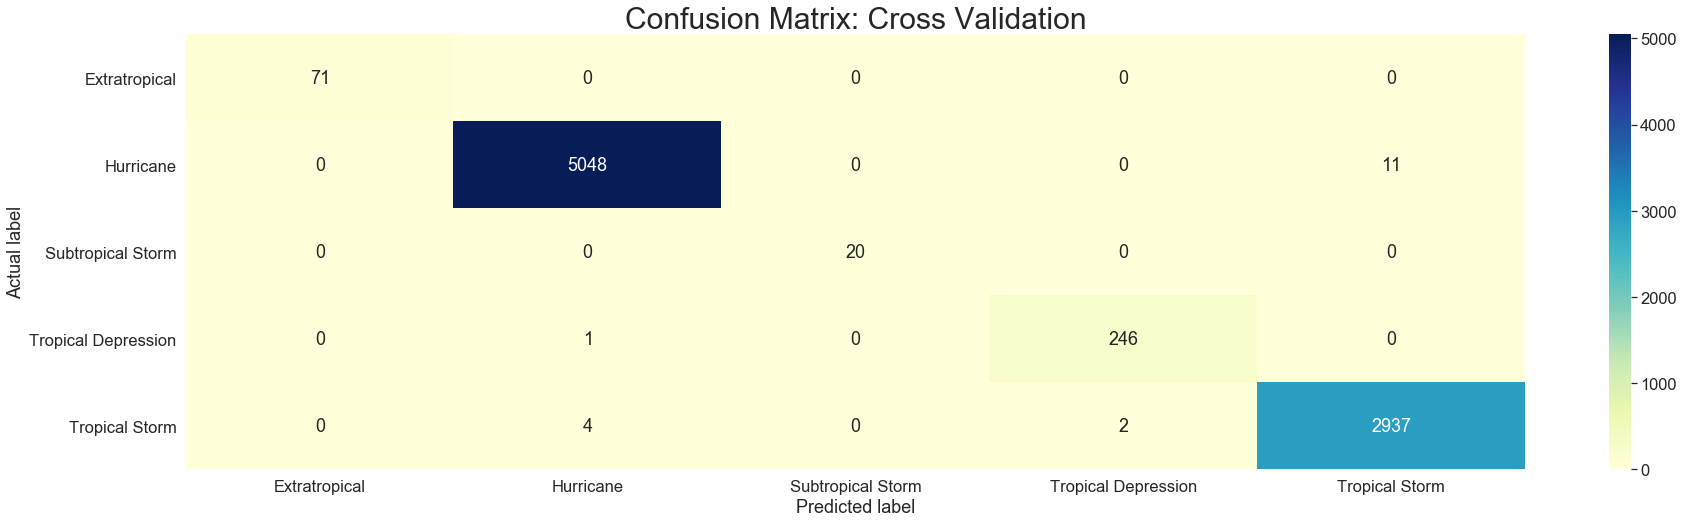

In [69]:
cf_val_matrix = confusion_matrix(y_train, y_val_pred)
chart=sb.heatmap(pd.DataFrame(cf_val_matrix), annot=True, cmap="YlGnBu",fmt='g')
chart.set_title('Confusion Matrix: Cross Validation', size=30)
chart.set_ylabel('Actual label')
chart.set_xlabel('Predicted label')
class_names=['Extratropical', 'Hurricane', 'Subtropical Storm', 'Tropical Depression', 'Tropical Storm']
chart.set_xticklabels(class_names, rotation=0)
chart.set_yticklabels(class_names, rotation=0);

#### Classification Report: Cross Validation

In [70]:
print(classification_report(y_train, y_val_pred))

                     precision    recall  f1-score   support

      Extratropical       1.00      1.00      1.00        71
          Hurricane       1.00      1.00      1.00      5059
  Subtropical Storm       1.00      1.00      1.00        20
Tropical Depression       0.99      1.00      0.99       247
     Tropical Storm       1.00      1.00      1.00      2943

           accuracy                           1.00      8340
          macro avg       1.00      1.00      1.00      8340
       weighted avg       1.00      1.00      1.00      8340



### Deploying and evaluating the model on the test set

In [71]:
y_pred = KNNModel.predict(norm_X_test)

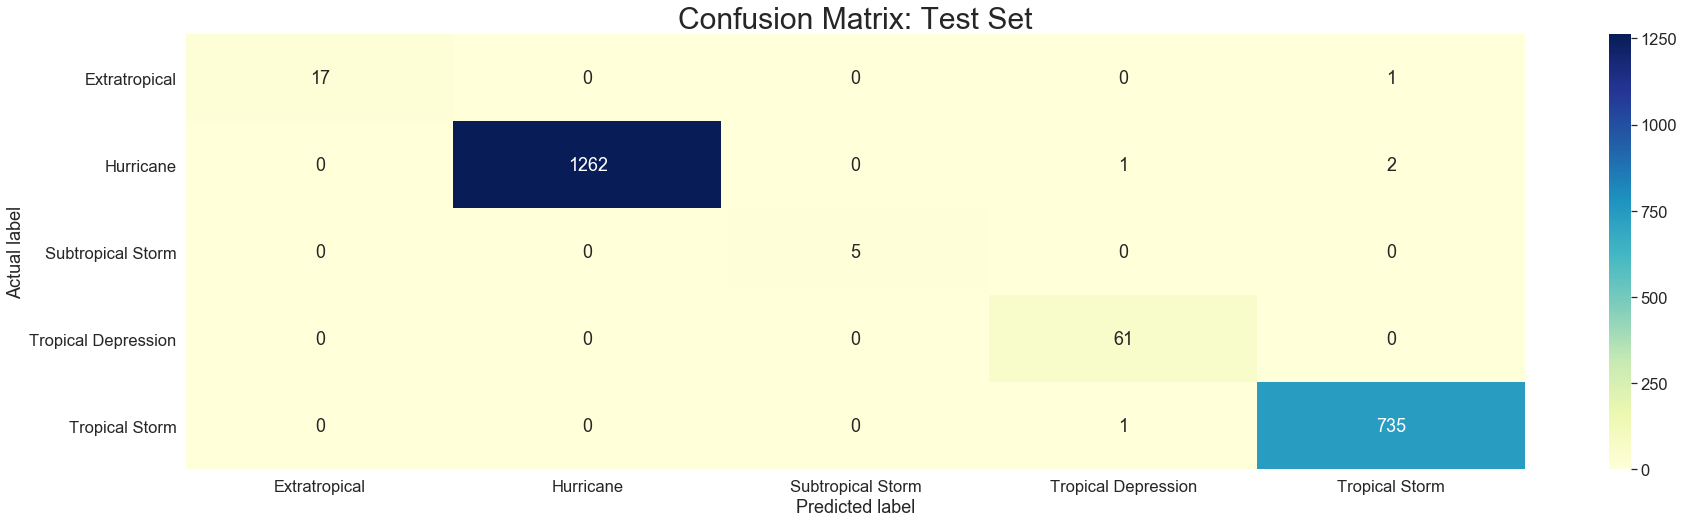

In [72]:
cf_test_matrix = confusion_matrix(y_test, y_pred)
chart=sb.heatmap(pd.DataFrame(cf_test_matrix), annot=True, cmap="YlGnBu", fmt='g')
chart.set_title('Confusion Matrix: Test Set', size=30)
chart.set_ylabel('Actual label')
chart.set_xlabel('Predicted label')
class_names=['Extratropical', 'Hurricane', 'Subtropical Storm', 'Tropical Depression', 'Tropical Storm']
chart.set_xticklabels(class_names, rotation=0)
chart.set_yticklabels(class_names, rotation=0);

#### Classification Report: Test Set

In [73]:
print(classification_report(y_test, y_pred))

                     precision    recall  f1-score   support

      Extratropical       1.00      0.94      0.97        18
          Hurricane       1.00      1.00      1.00      1265
  Subtropical Storm       1.00      1.00      1.00         5
Tropical Depression       0.97      1.00      0.98        61
     Tropical Storm       1.00      1.00      1.00       736

           accuracy                           1.00      2085
          macro avg       0.99      0.99      0.99      2085
       weighted avg       1.00      1.00      1.00      2085



# Decision Trees

### Hyperparameter Tuning

In [74]:
from sklearn import tree
from IPython.display import Image
import pydotplus

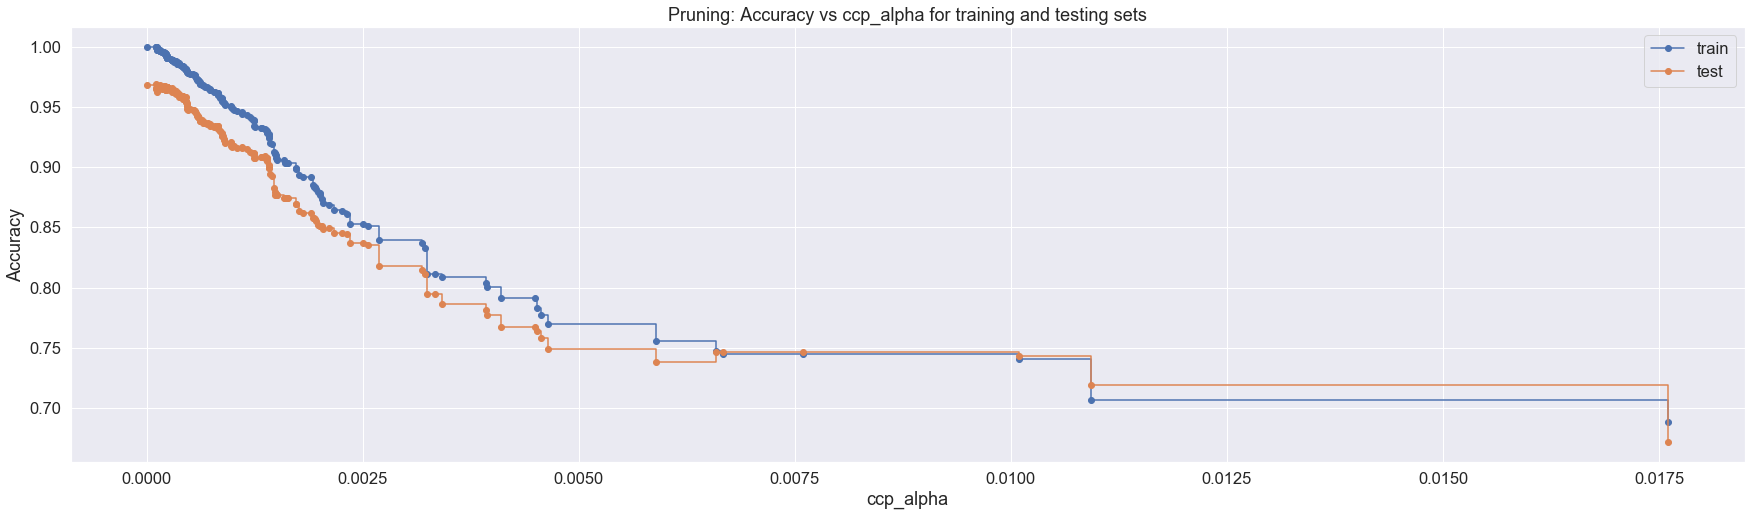

In [75]:
from sklearn.tree import DecisionTreeClassifier
clf = DecisionTreeClassifier()
path = clf.cost_complexity_pruning_path(norm_X_train, y_train)
ccp_alphas, impurities = path.ccp_alphas, path.impurities
clfs = []
for ccp_alpha in ccp_alphas:
    clf = DecisionTreeClassifier(ccp_alpha=ccp_alpha)
    clf.fit(norm_X_train, y_train)
    clfs.append(clf)
    
clfs = clfs[:-1]
ccp_alphas = ccp_alphas[:-1]

train_scores = [clf.score(norm_X_train, y_train) for clf in clfs]
test_scores = [clf.score(norm_X_test, y_test) for clf in clfs]

fig, ax = plt.subplots()
ax.set_xlabel("ccp_alpha")
ax.set_ylabel("Accuracy")
ax.set_title("Pruning: Accuracy vs ccp_alpha for training and testing sets")
ax.plot(ccp_alphas, train_scores, marker='o', label="train",
        drawstyle="steps-post")
ax.plot(ccp_alphas, test_scores, marker='o', label="test",
        drawstyle="steps-post")
ax.legend()
plt.show()


In order to avoid overfitting and create a decision tree that generalizes better, we want to determine the optimal ccp_alpha (Minimal Cost-Complexity Pruning. With the other parameters kept at their default values, the ccp_alpha  was varied. As seen above, the test accuracy is highest at ccp_alpha=0, which is also the value at which trainning accuracy is the highest. In fact, we obtain the perfect model with the default parameters.

Hence, we will use other parameters such as max_depth and min_impurity_decrease and min_samples_leaf to prune our decision tree.

In [76]:
DT = tree.DecisionTreeClassifier()
parameters= {'criterion': ('gini','entropy'), 'max_depth': [5,6,7,8,9,10],
            'min_samples_split': [5,10,20,30,40], 'min_samples_leaf': [10,20,30], 'class_weight': ('balanced',None), 
             'min_impurity_decrease':[0.05,0.01,0.005,0.001]}


gdt = GridSearchCV(DT, parameters, cv=cv_method, scoring='f1_macro', refit=True)

In [77]:
gdt.fit(norm_X_train, y_train)
print('The best model is:', gdt.best_estimator_)
print('which yielded a mean macro f1_score of', gdt.best_score_)

The best model is: DecisionTreeClassifier(class_weight='balanced', criterion='entropy',
                       max_depth=10, min_impurity_decrease=0.001,
                       min_samples_leaf=10, min_samples_split=10)
which yielded a mean macro f1_score of 0.8561323752161802


### Model

In [78]:
DTModel=gdt.best_estimator_

In [79]:
y_train_pred = DTModel.predict(norm_X_train)

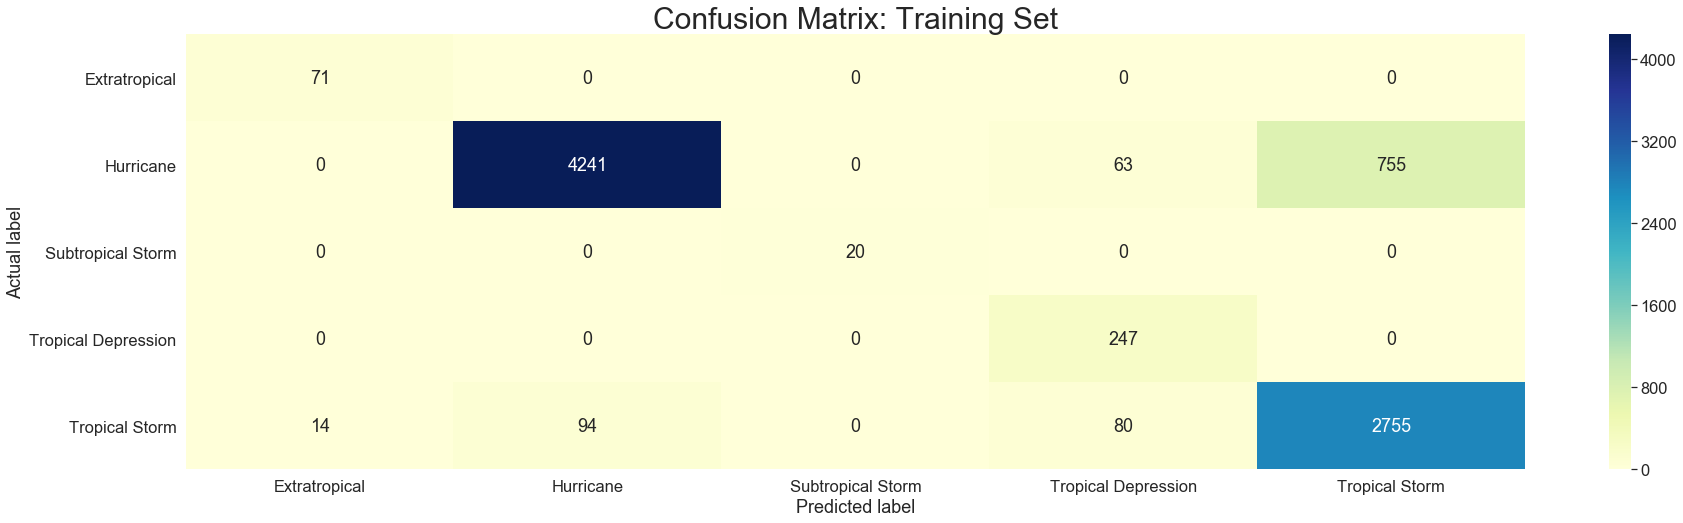

In [80]:
cf_train_matrix = confusion_matrix(y_train, y_train_pred)
class_names=('Extratropical', 'Hurricane', 'Subtropical Storm', 'Tropical Depression', 'Tropical Storm') # name  of classes
# create heatmap
chart=sb.heatmap(pd.DataFrame(cf_train_matrix), annot=True, cmap="YlGnBu",fmt='g')
chart.set_title('Confusion Matrix: Training Set', size=30)
chart.set_ylabel('Actual label')
chart.set_xlabel('Predicted label')
class_names=['Extratropical', 'Hurricane', 'Subtropical Storm', 'Tropical Depression', 'Tropical Storm']
chart.set_xticklabels(class_names, rotation=0)
chart.set_yticklabels(class_names, rotation=0);

#### Classification Report: Training Set

In [81]:
print(classification_report(y_train, y_train_pred))

                     precision    recall  f1-score   support

      Extratropical       0.84      1.00      0.91        71
          Hurricane       0.98      0.84      0.90      5059
  Subtropical Storm       1.00      1.00      1.00        20
Tropical Depression       0.63      1.00      0.78       247
     Tropical Storm       0.78      0.94      0.85      2943

           accuracy                           0.88      8340
          macro avg       0.85      0.95      0.89      8340
       weighted avg       0.90      0.88      0.88      8340



#### Decision Tree Visualization

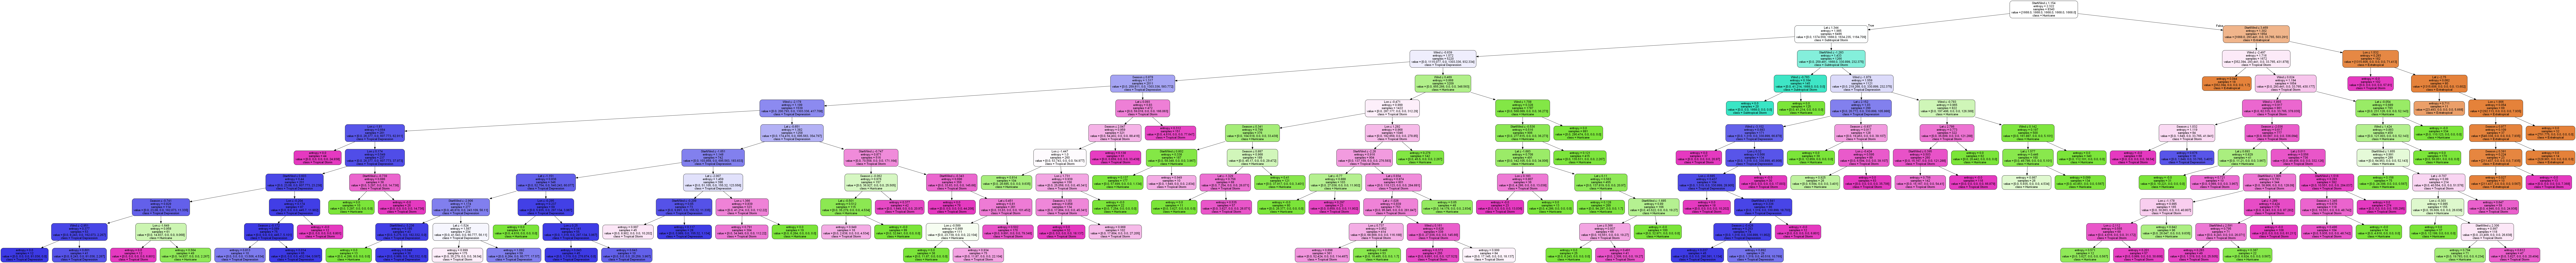

In [82]:
metrics_names=['Wind', 'StartWind', 'Lat', 'Lon' , 'Season']
dot_data = tree.export_graphviz(DTModel, out_file=None, feature_names=metrics_names, class_names=DTModel.classes_,
                                filled=True, rounded=True,  special_characters=True) 
graph = pydotplus.graph_from_dot_data(dot_data) 
Image(graph.create_png())

### Cross Validation

In [83]:
y_val_pred = cross_val_predict(DTModel, norm_X_train, y_train, cv = cv_method)

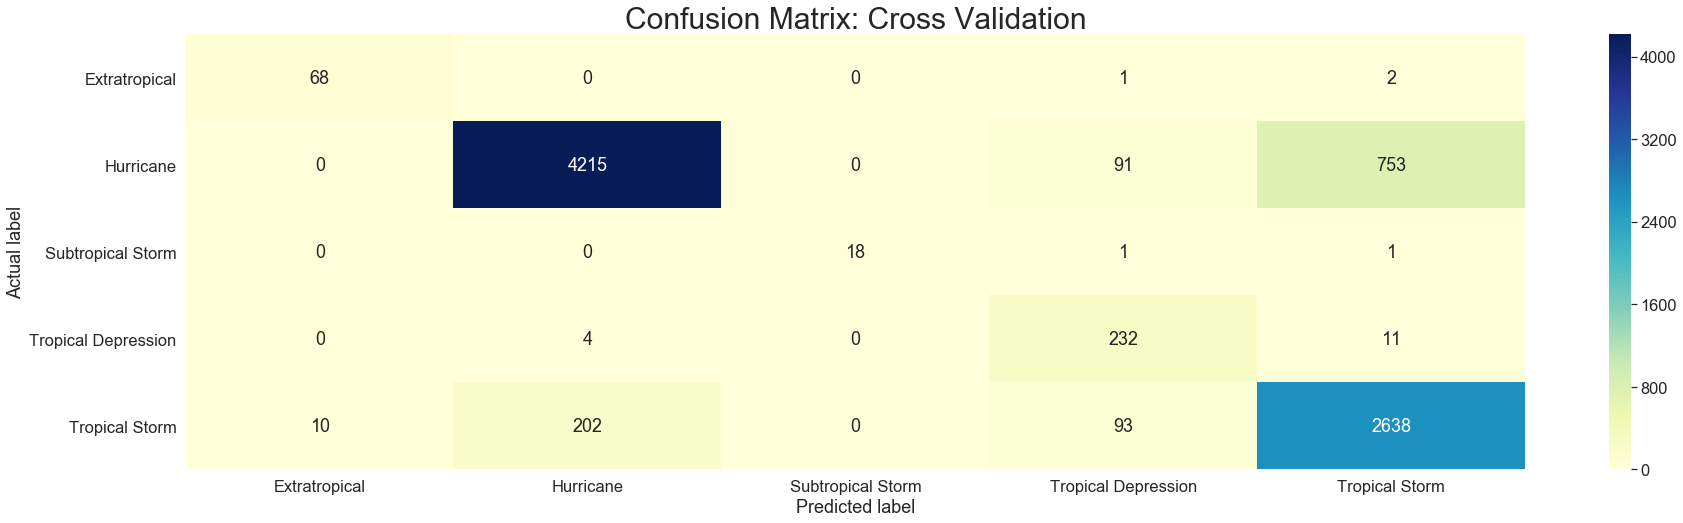

In [84]:
cf_val_matrix = confusion_matrix(y_train, y_val_pred)
chart=sb.heatmap(pd.DataFrame(cf_val_matrix), annot=True, cmap="YlGnBu",fmt='g')
chart.set_title('Confusion Matrix: Cross Validation', size=30)
chart.set_ylabel('Actual label')
chart.set_xlabel('Predicted label')
class_names=['Extratropical', 'Hurricane', 'Subtropical Storm', 'Tropical Depression', 'Tropical Storm']
chart.set_xticklabels(class_names, rotation=0)
chart.set_yticklabels(class_names, rotation=0);

#### Classification Report: Cross Validation

In [85]:
print(classification_report(y_train, y_val_pred))

                     precision    recall  f1-score   support

      Extratropical       0.87      0.96      0.91        71
          Hurricane       0.95      0.83      0.89      5059
  Subtropical Storm       1.00      0.90      0.95        20
Tropical Depression       0.56      0.94      0.70       247
     Tropical Storm       0.77      0.90      0.83      2943

           accuracy                           0.86      8340
          macro avg       0.83      0.91      0.86      8340
       weighted avg       0.88      0.86      0.86      8340



### Deploying and evaluating the model on the test set

In [86]:
y_pred = DTModel.predict(norm_X_test)

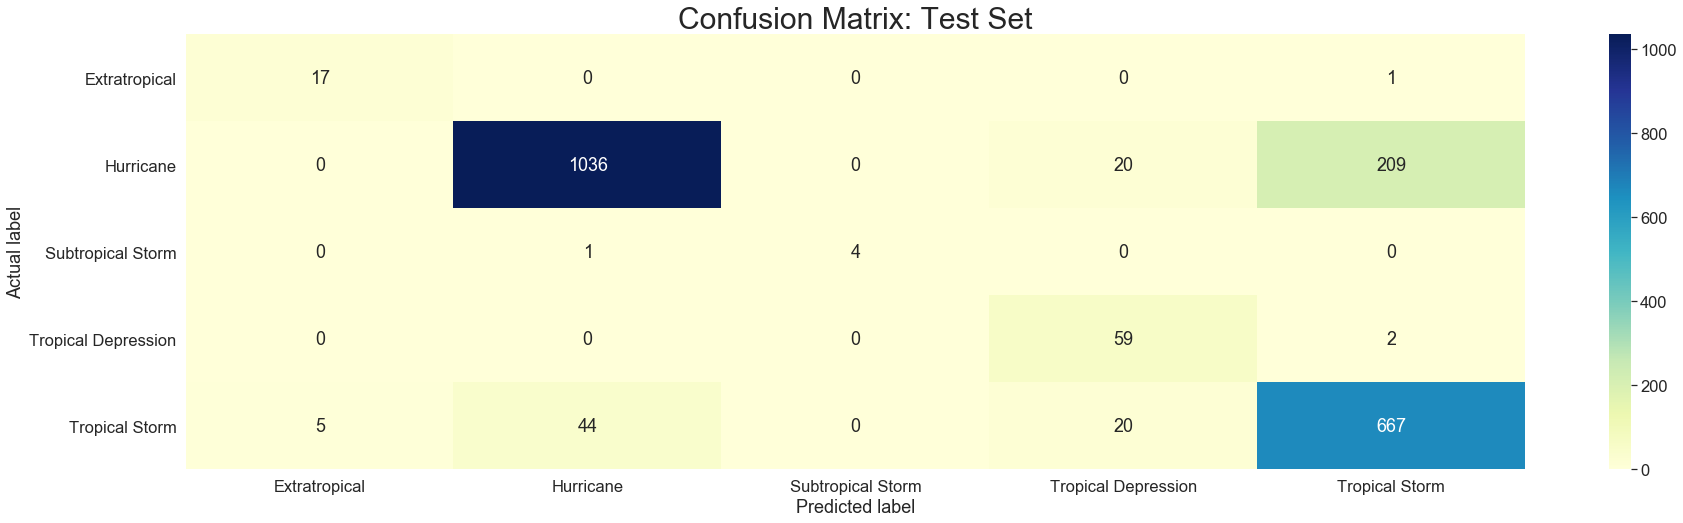

In [87]:
cf_test_matrix = confusion_matrix(y_test, y_pred)
chart=sb.heatmap(pd.DataFrame(cf_test_matrix), annot=True, cmap="YlGnBu", fmt='g')
chart.set_title('Confusion Matrix: Test Set', size=30)
chart.set_ylabel('Actual label')
chart.set_xlabel('Predicted label')
class_names=['Extratropical', 'Hurricane', 'Subtropical Storm', 'Tropical Depression', 'Tropical Storm']
chart.set_xticklabels(class_names, rotation=0)
chart.set_yticklabels(class_names, rotation=0);

#### Classification Report: Test Set

In [88]:
print(classification_report(y_test, y_pred))

                     precision    recall  f1-score   support

      Extratropical       0.77      0.94      0.85        18
          Hurricane       0.96      0.82      0.88      1265
  Subtropical Storm       1.00      0.80      0.89         5
Tropical Depression       0.60      0.97      0.74        61
     Tropical Storm       0.76      0.91      0.83       736

           accuracy                           0.86      2085
          macro avg       0.82      0.89      0.84      2085
       weighted avg       0.88      0.86      0.86      2085



# Random Forest

In [89]:
from sklearn.ensemble import RandomForestClassifier

In [90]:
RD = RandomForestClassifier(criterion='entropy', max_depth=10, min_impurity_decrease=0.001, min_samples_leaf=10,
                                 min_samples_split=20)

parameters= {'n_estimators': [50,100,150,200], 'bootstrap': [True, False]}


grd = GridSearchCV(RD, parameters, cv=cv_method, scoring='f1_macro', refit=True)

In [91]:
grd.fit(norm_X_train, y_train)
print('The best model is:', grd.best_estimator_)
print('which yielded a mean macro f1_score of', grd.best_score_)

The best model is: RandomForestClassifier(bootstrap=False, criterion='entropy', max_depth=10,
                       min_impurity_decrease=0.001, min_samples_leaf=10,
                       min_samples_split=20)
which yielded a mean macro f1_score of 0.9432424576007182


### Model

In [92]:
RDModel=grd.best_estimator_

In [93]:
y_train_pred = RDModel.predict(norm_X_train)

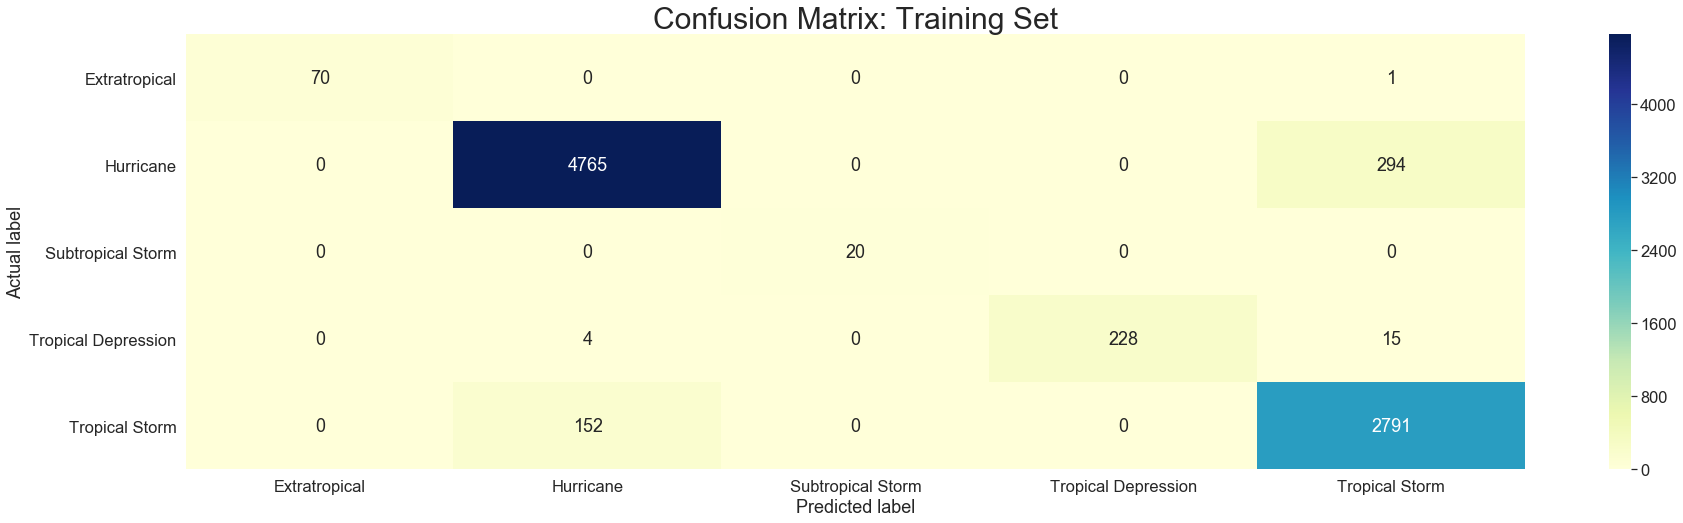

In [94]:
cf_train_matrix = confusion_matrix(y_train, y_train_pred)
class_names=('Extratropical', 'Hurricane', 'Subtropical Storm', 'Tropical Depression', 'Tropical Storm') # name  of classes
# create heatmap
chart=sb.heatmap(pd.DataFrame(cf_train_matrix), annot=True, cmap="YlGnBu",fmt='g')
chart.set_title('Confusion Matrix: Training Set', size=30)
chart.set_ylabel('Actual label')
chart.set_xlabel('Predicted label')
class_names=['Extratropical', 'Hurricane', 'Subtropical Storm', 'Tropical Depression', 'Tropical Storm']
chart.set_xticklabels(class_names, rotation=0)
chart.set_yticklabels(class_names, rotation=0);

#### Classification Report: Training Set

In [95]:
print(classification_report(y_train, y_train_pred))

                     precision    recall  f1-score   support

      Extratropical       1.00      0.99      0.99        71
          Hurricane       0.97      0.94      0.95      5059
  Subtropical Storm       1.00      1.00      1.00        20
Tropical Depression       1.00      0.92      0.96       247
     Tropical Storm       0.90      0.95      0.92      2943

           accuracy                           0.94      8340
          macro avg       0.97      0.96      0.97      8340
       weighted avg       0.95      0.94      0.94      8340



#### Visualization of the first 5 trees of the Random Forest

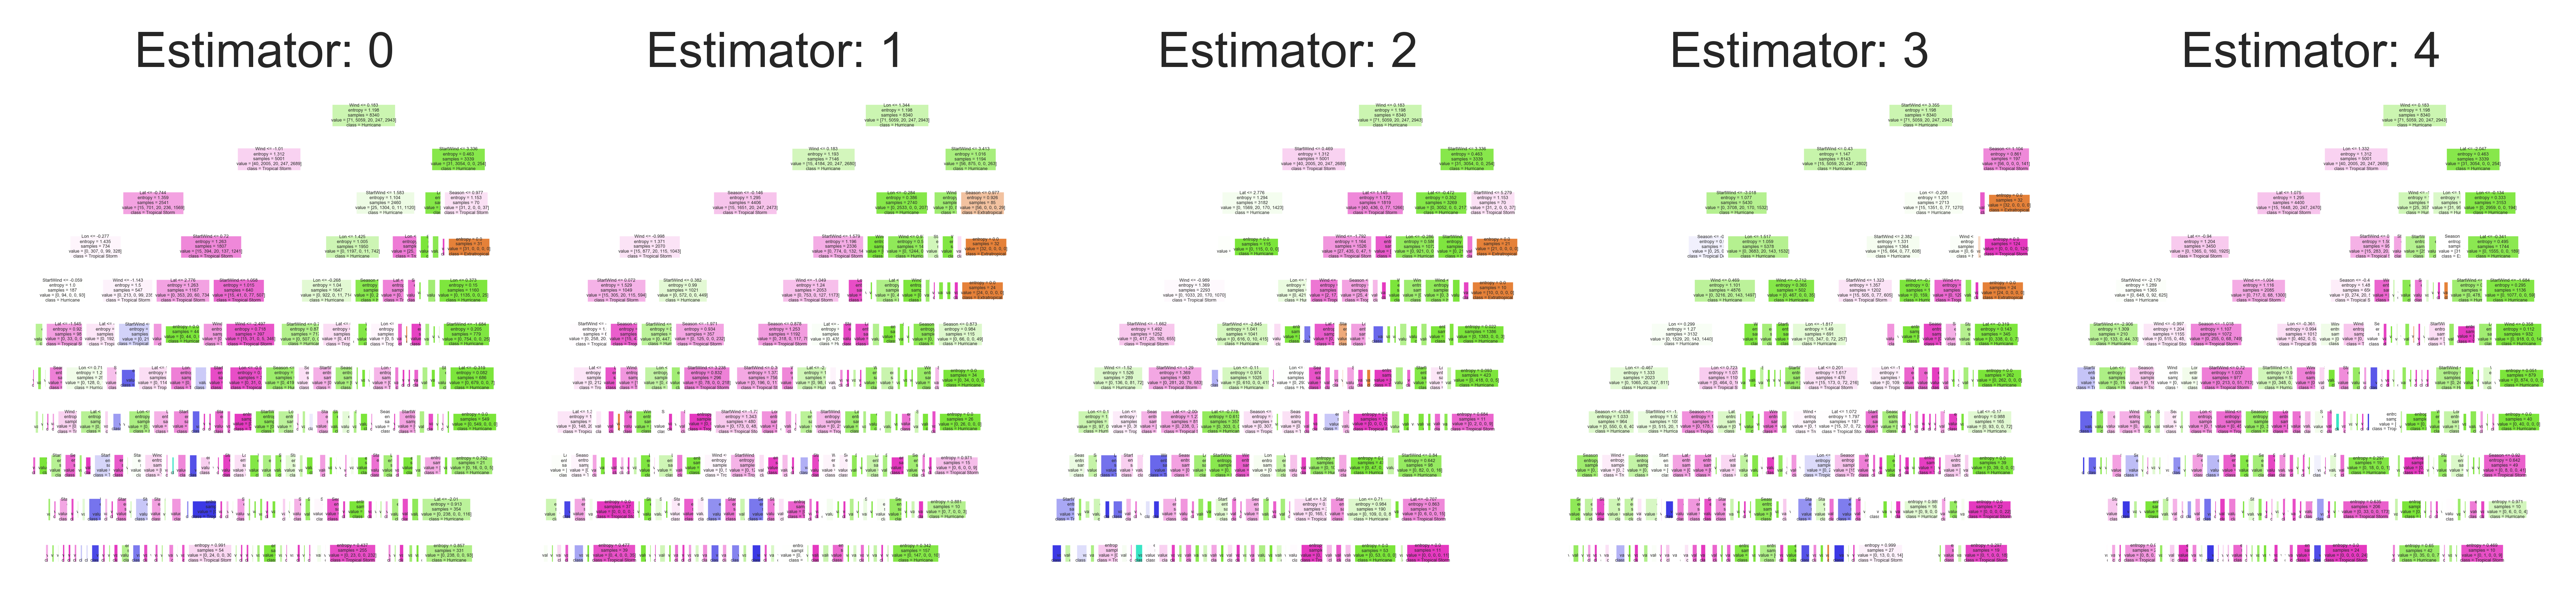

In [96]:
fig, axes = plt.subplots(nrows = 1,ncols = 5,figsize = (10,2), dpi=900)
for index in range(0, 5):
    tree.plot_tree(RDModel.estimators_[index],
                   feature_names=metrics_names, 
                   class_names=RDModel.classes_,
                   filled = True,
                   ax = axes[index]);

    axes[index].set_title('Estimator: ' + str(index), fontsize = 11)
fig.savefig('rf_5trees.png')

### Cross Validation

In [97]:
y_val_pred = cross_val_predict(RDModel, norm_X_train, y_train, cv = cv_method)

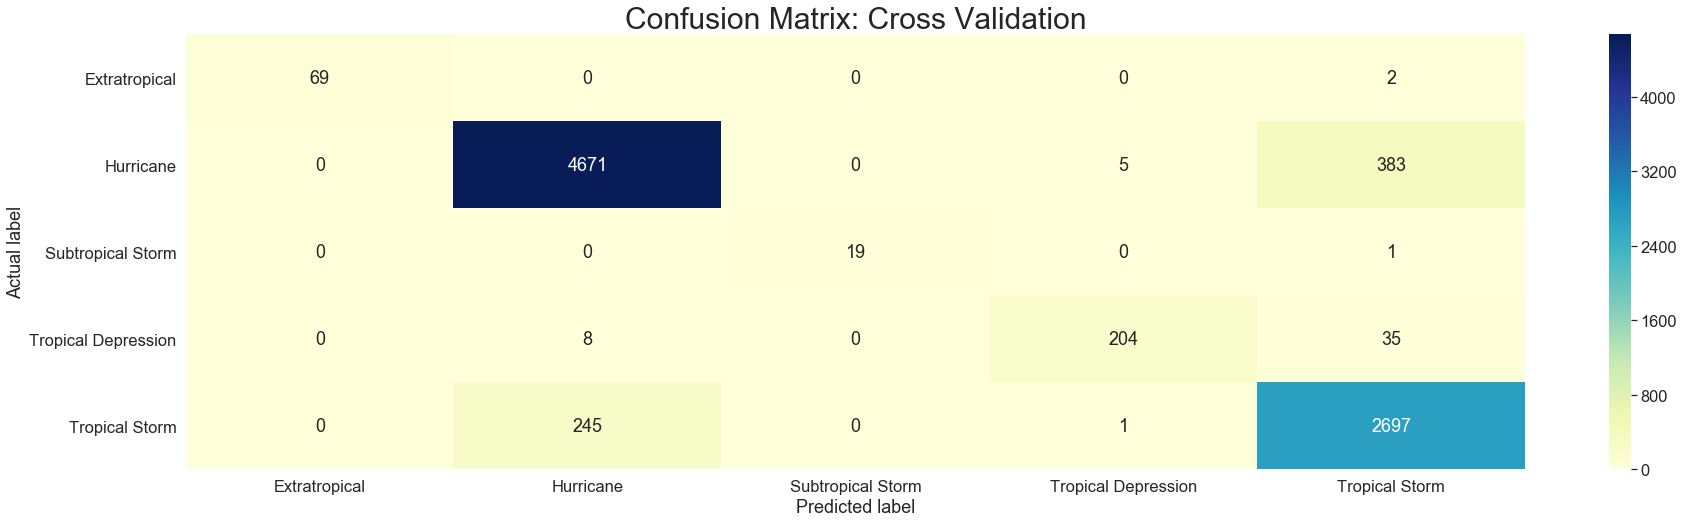

In [98]:
cf_val_matrix = confusion_matrix(y_train, y_val_pred)
chart=sb.heatmap(pd.DataFrame(cf_val_matrix), annot=True, cmap="YlGnBu",fmt='g')
chart.set_title('Confusion Matrix: Cross Validation', size=30)
chart.set_ylabel('Actual label')
chart.set_xlabel('Predicted label')
class_names=['Extratropical', 'Hurricane', 'Subtropical Storm', 'Tropical Depression', 'Tropical Storm']
chart.set_xticklabels(class_names, rotation=0)
chart.set_yticklabels(class_names, rotation=0);

#### Classification Report: Cross Validation

In [99]:
print(classification_report(y_train, y_val_pred))

                     precision    recall  f1-score   support

      Extratropical       1.00      0.97      0.99        71
          Hurricane       0.95      0.92      0.94      5059
  Subtropical Storm       1.00      0.95      0.97        20
Tropical Depression       0.97      0.83      0.89       247
     Tropical Storm       0.86      0.92      0.89      2943

           accuracy                           0.92      8340
          macro avg       0.96      0.92      0.94      8340
       weighted avg       0.92      0.92      0.92      8340



### Deploying and evaluating the model on the test set

In [100]:
y_pred = RDModel.predict(norm_X_test)

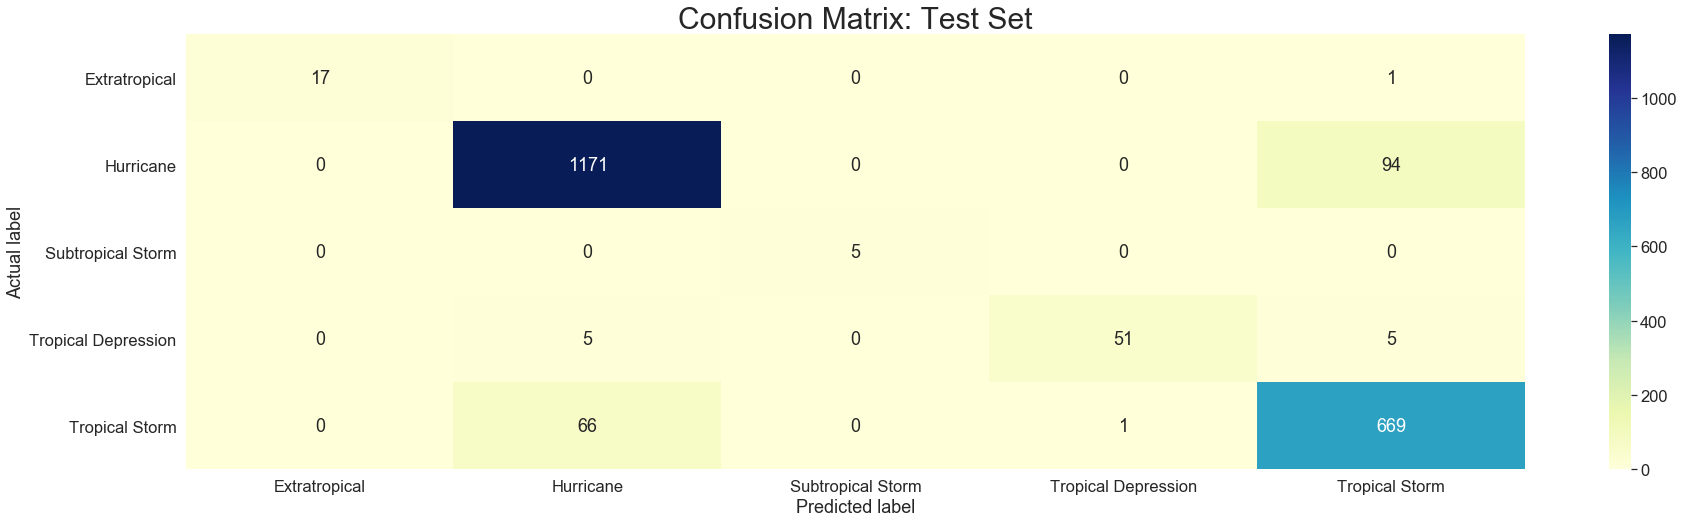

In [101]:
cf_test_matrix = confusion_matrix(y_test, y_pred)
chart=sb.heatmap(pd.DataFrame(cf_test_matrix), annot=True, cmap="YlGnBu", fmt='g')
chart.set_title('Confusion Matrix: Test Set', size=30)
chart.set_ylabel('Actual label')
chart.set_xlabel('Predicted label')
class_names=['Extratropical', 'Hurricane', 'Subtropical Storm', 'Tropical Depression', 'Tropical Storm']
chart.set_xticklabels(class_names, rotation=0)
chart.set_yticklabels(class_names, rotation=0);

#### Classification Report: Test Set

In [102]:
print(classification_report(y_test, y_pred))

                     precision    recall  f1-score   support

      Extratropical       1.00      0.94      0.97        18
          Hurricane       0.94      0.93      0.93      1265
  Subtropical Storm       1.00      1.00      1.00         5
Tropical Depression       0.98      0.84      0.90        61
     Tropical Storm       0.87      0.91      0.89       736

           accuracy                           0.92      2085
          macro avg       0.96      0.92      0.94      2085
       weighted avg       0.92      0.92      0.92      2085



# 7) Discussion and Conclusion for Question C
Similar to part 1, the logistic regression and Naive Bayes models are performing poorly compared to the KNN, decision  tree and Random Forest models. Hence, we can conclude that logistic regression and Naive Bayes estimatorsare not suitable for this question and daaset.
Although sligly lower, the performance metrics of the Knn, decison tree and Random Forest models are still high despite the fact that we decreased the number of features from 9 to 5. Hence, we can predict the maximum strenght of a storm at a high accuracy rate using only the current wind(mph), starting wind (mph), current lattitude, longitude and season of the storm using either KNN, decison tree or random forest classifiers.